## Explatory Data Analaysis for Airbnb Dataset 
- New York and London cities

In [19]:
## IMPORTING NECESSARY PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import SimpleImputer
from wordcloud import WordCloud

## Suppress all warnings
warnings.filterwarnings('ignore')

## Set visualization style
sns.set(style="whitegrid")

#### 1. Data Loading

In [20]:
## Load listings data  (NYC)
nyc_train = pd.read_csv('Dataset/nyc_train.csv')  

## Load reviews data  (london)
london_train = pd.read_csv('Dataset/london_train.csv')  

In [21]:
## Concat the cities
train_set = pd.concat([nyc_train, london_train], axis=0)

#### 2. Data Overview

In [22]:
## DATA VIEW 
print('NUMBER OF RECORDS: ', train_set.shape[0])
print('NUMBER OF FEATURES:', train_set.shape[1])
print('FEATURE LIST:', train_set.columns.to_list())

NUMBER OF RECORDS:  1990488
NUMBER OF FEATURES: 29
FEATURE LIST: ['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'neighborhood_overview', 'host_id', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'city', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments', 'polarity', 'polarity_class']


#### 3. Data Cleaning

In [23]:
## View Basic Information about the Dataset
print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1990488 entries, 0 to 1291314
Data columns (total 29 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   listing_id                      int64  
 1   listing_url                     object 
 2   scrape_id                       int64  
 3   last_scraped                    object 
 4   name                            object 
 5   neighborhood_overview           object 
 6   host_id                         int64  
 7   number_of_reviews               int64  
 8   number_of_reviews_ltm           int64  
 9   number_of_reviews_l30d          int64  
 10  first_review                    object 
 11  last_review                     object 
 12  review_scores_rating            float64
 13  review_scores_accuracy          float64
 14  review_scores_cleanliness       float64
 15  review_scores_checkin           float64
 16  review_scores_communication     float64
 17  review_scores_location          

In [24]:
## Summary statistics of categorical columns
print(train_set.describe(include=['object']))

                                  listing_url last_scraped  \
count                                 1990488      1990488   
unique                                  90646            6   
top     https://www.airbnb.com/rooms/37122502   2024-06-15   
freq                                     1412       517897   

                                                   name  \
count                                           1990472   
unique                                            88387   
top     Double Garden View room - London House Hotel***   
freq                                               2149   

                                    neighborhood_overview first_review  \
count                                             1477353      1990488   
unique                                              44888         4558   
top     The apartment is perfectly sandwiched between ...   2015-09-21   
freq                                                 6632         3189   

       last_review    

In [25]:
## Check for missing values  
print("Missing Values in the Training Set")  
listings_nan_counts = train_set.isnull().sum()
print(listings_nan_counts[listings_nan_counts > 0])  

Missing Values in the Training Set
name                               16
neighborhood_overview          513135
review_scores_accuracy             63
review_scores_cleanliness          55
review_scores_checkin              90
review_scores_communication        68
review_scores_location             94
review_scores_value                92
reviewer_name                       1
dtype: int64


In [26]:
## Ways of addressing the nan values
# 1. 'name': Fill missing values with the most frequent value (mode)
train_set['name'].fillna(train_set['name'].mode()[0], inplace=True)

# 2. 'neighborhood_overview': Dropping this column due to a large number of missing values 
train_set.drop(columns=['neighborhood_overview'], axis=1, inplace=True)

# For review score columns, we can use the mean or median for imputation
review_score_columns = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                        'review_scores_communication', 'review_scores_location', 'review_scores_value']

## Imputer instance for imputing the numerical values using the mean value
mean_imputer = SimpleImputer(strategy='mean')

# Apply mean imputation to the review score columns
train_set[review_score_columns] = mean_imputer.fit_transform(train_set[review_score_columns])

# 3. 'reviewer_name': Fill missing values with the most frequent value (mode)
train_set['reviewer_name'].fillna(train_set['reviewer_name'].mode()[0], inplace=True)

In [27]:
## Rechecking for missing values  
print("Missing Values after imputation:")  
listings_nan_counts = train_set.isnull().sum()
print(listings_nan_counts[listings_nan_counts > 0])  

Missing Values after imputation:
Series([], dtype: int64)


#### 4. Data Visualization
#### Q.1: How do the distributions of various review scores compare between New York City (NYC) and London for Airbnb listings?

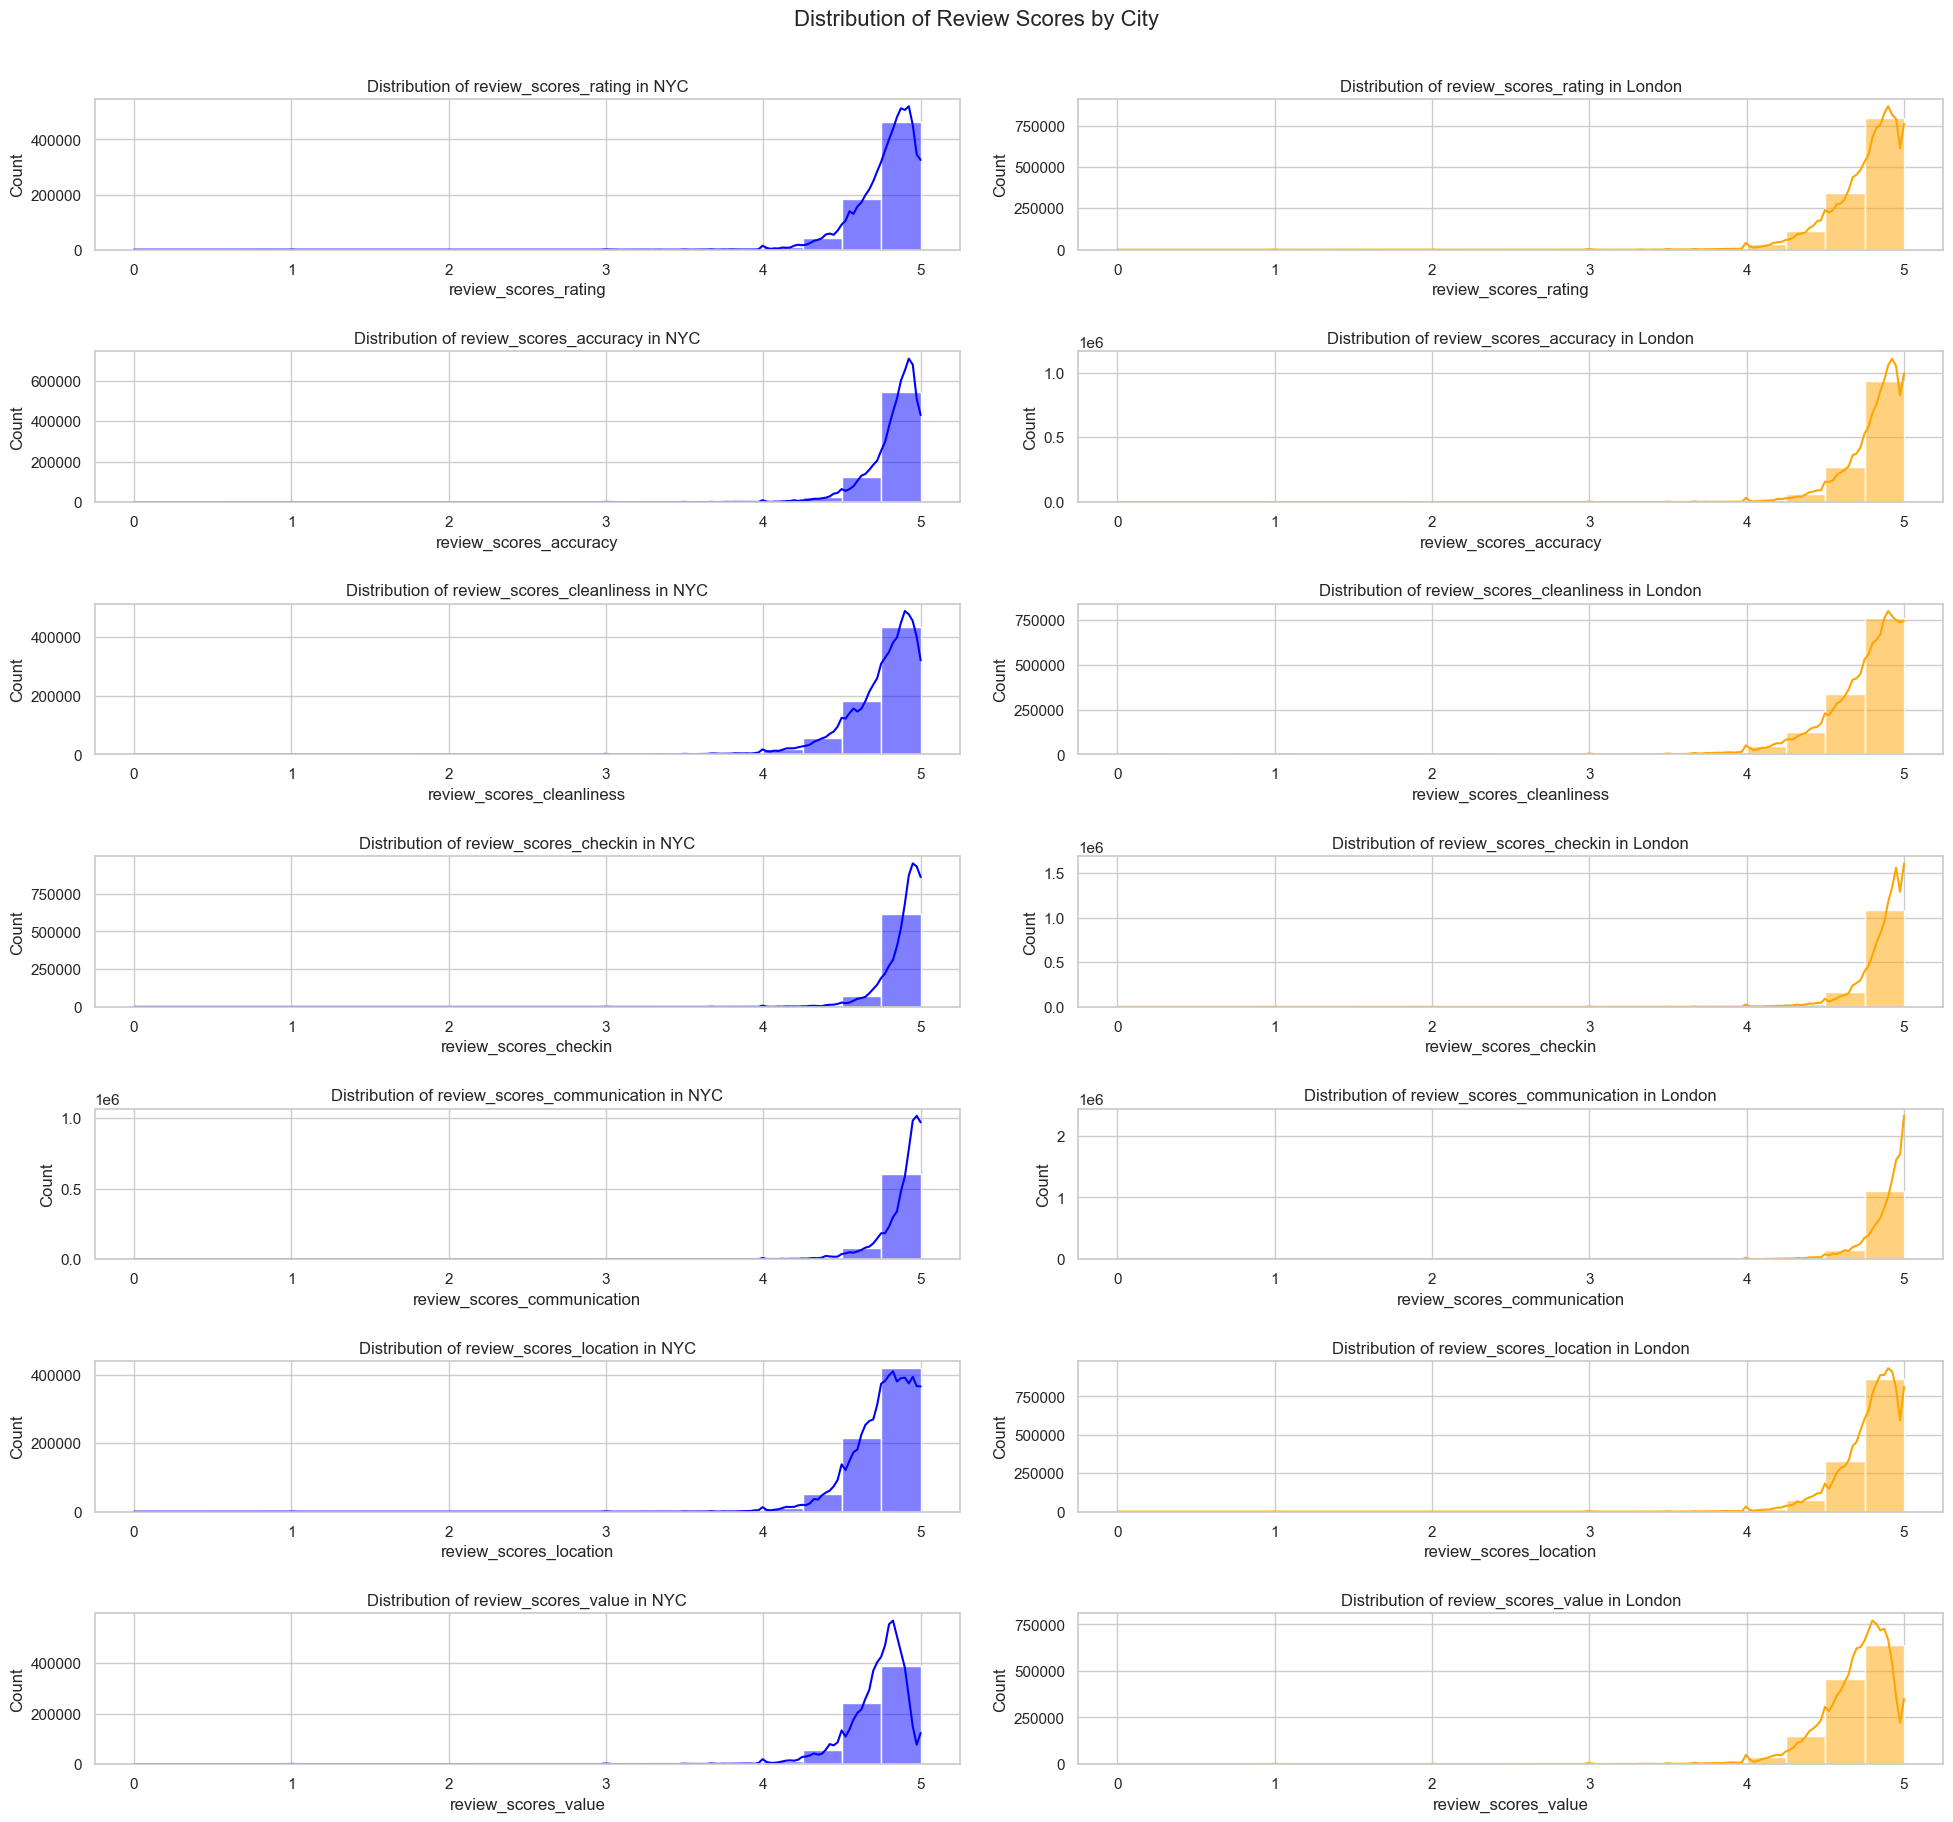

In [28]:
## Distribution of review scores
review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                  'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                  'review_scores_value']

## Create a figure for plotting
plt.figure(figsize=(20, 18))

## Iterate over each review type to create subplots
for i, column in enumerate(review_columns, 1):
    plt.subplot(len(review_columns), 2, i*2-1)
    sns.histplot(train_set[train_set['city']=='nyc'][column], bins=20, kde=True, color='blue')
    plt.title(f'Distribution of {column} in NYC')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.subplot(len(review_columns), 2, i*2)
    sns.histplot(train_set[train_set['city']=='london'][column], bins=20, kde=True, color='orange')
    plt.title(f'Distribution of {column} in London')
    plt.xlabel(column)
    plt.ylabel('Count')

## Show plot
plt.tight_layout(pad=2.0)
plt.suptitle('Distribution of Review Scores by City', y=1.02, fontsize=16)
plt.show()

***Insights:***
- London reviewers tend to give higher ratings across all categories compared to NYC reviewers.
- Also, it seems the distributions of review scores in London are a little more spread out, indicating more diverse opinions compared to the more concentrated distributions in NYC.

#### Q.2: How has the number of Airbnb listings changed over time in different cities?

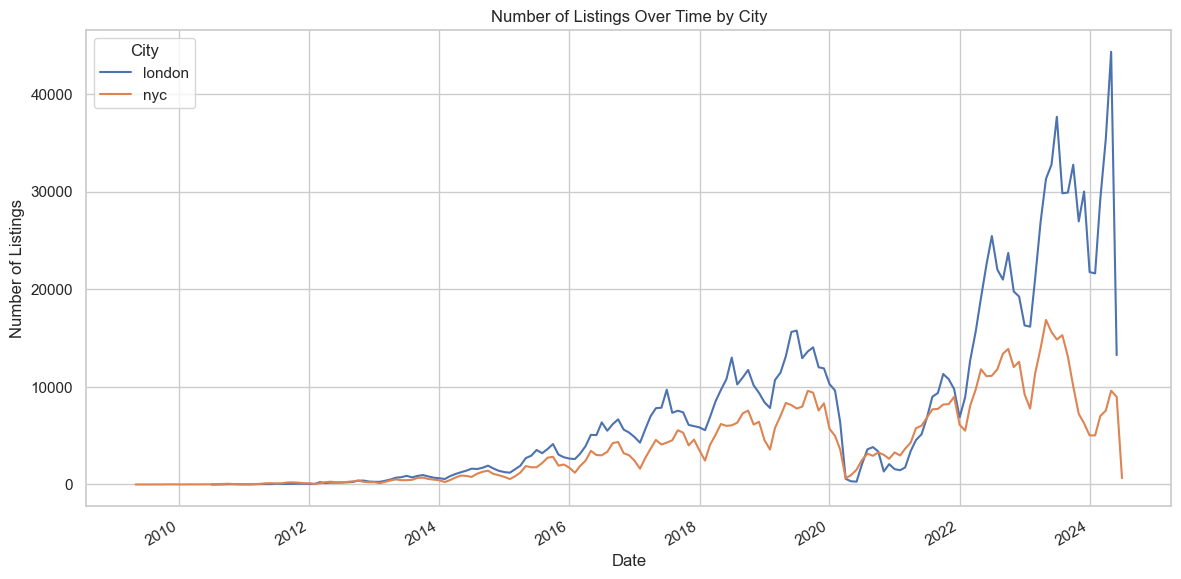

In [32]:
## Group by city and month, and count the number of listings
listings_over_time = train_set.groupby(['city', train_set['date'].dt.to_period('M')])['listing_id'].count().unstack(level=0)

## Convert PeriodIndex to Timestamp for plotting
listings_over_time.index = listings_over_time.index.to_timestamp()

## Plot number of listings over time for both cities
plt.figure(figsize=(14, 7))
listings_over_time.plot(kind='line', ax=plt.gca())
plt.title('Number of Listings Over Time by City')
plt.xlabel('Date')
plt.ylabel('Number of Listings')
plt.legend(title='City')
plt.show()

***Insights:***
- London consistently outperforms NYC in terms of the number of listings, demonstrating a stronger and more established market presence. However, NYC is experiencing faster growth, indicating a potential shift in market dynamics.

- Both cities exhibit fluctuations in listings, with a notable surge in 2022 followed by a recent decline. NYC's growth rate surpasses London's, suggesting a more dynamic and rapidly evolving market, but also potentially higher volatility.

#### Q.3: Who are the top ten hosts with the most Airbnb listings, and how many listings do they each have?

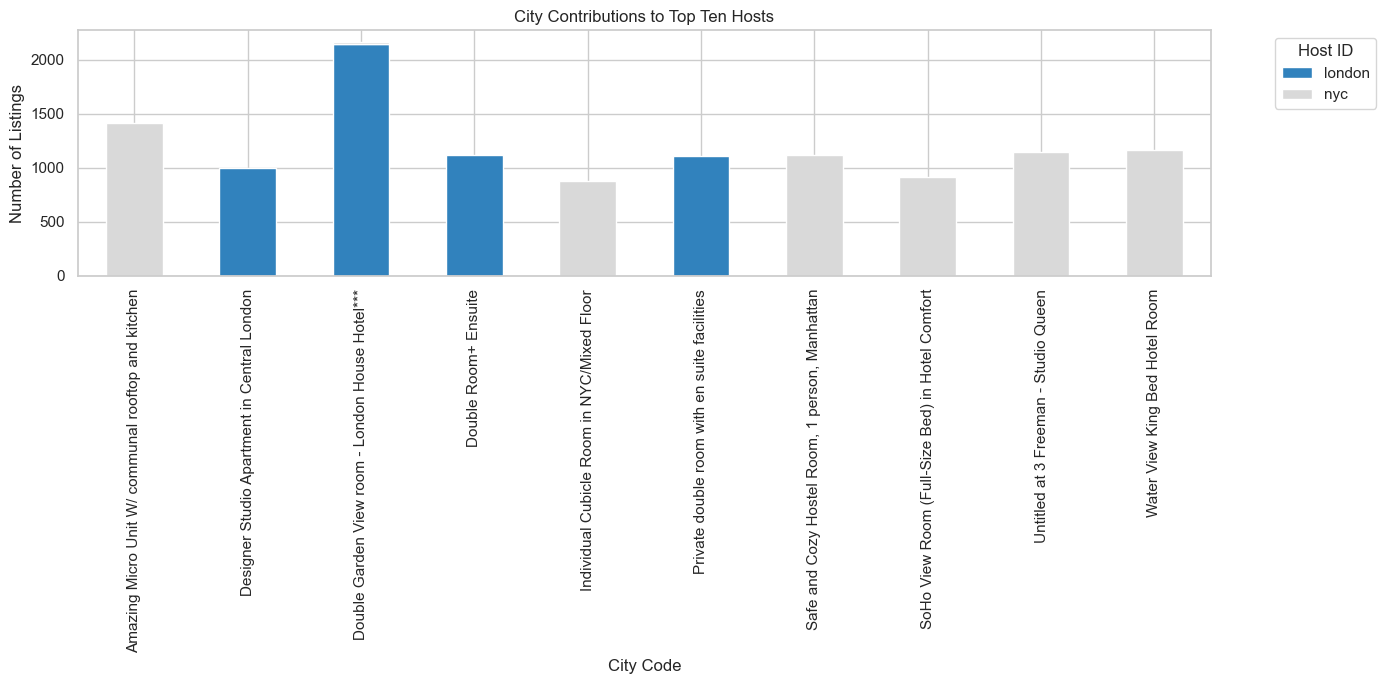

In [33]:
## Identify the top ten hosts based on the number of listings
top_hosts = train_set['name'].value_counts().nlargest(10).index

## Filter the dataset for the top ten hosts
top_hosts_listings = train_set[train_set['name'].isin(top_hosts)]

## Determine each city's contribution to the top ten hosts
city_contributions = top_hosts_listings.groupby(['name', 'city']).size().unstack(fill_value=0)

## Plotting the data
plt.figure(figsize=(14, 7))
city_contributions.plot(kind='bar', stacked=True, colormap='tab20c', ax=plt.gca())
plt.title('City Contributions to Top Ten Hosts')
plt.xlabel('City Code')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90)
plt.legend(title='Host ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

***Insights:***
- Among 437,364 listings and 62,867 unique hosts, the top ten hosts each manage between approximately 250 to 600 listings.<br>
- It appears that NYC dominates the top ten listings, with 6 out of the top ten hosts located in the city.

#### Q.4: What is the class balance of sentiment (polarity) in Airbnb reviews?

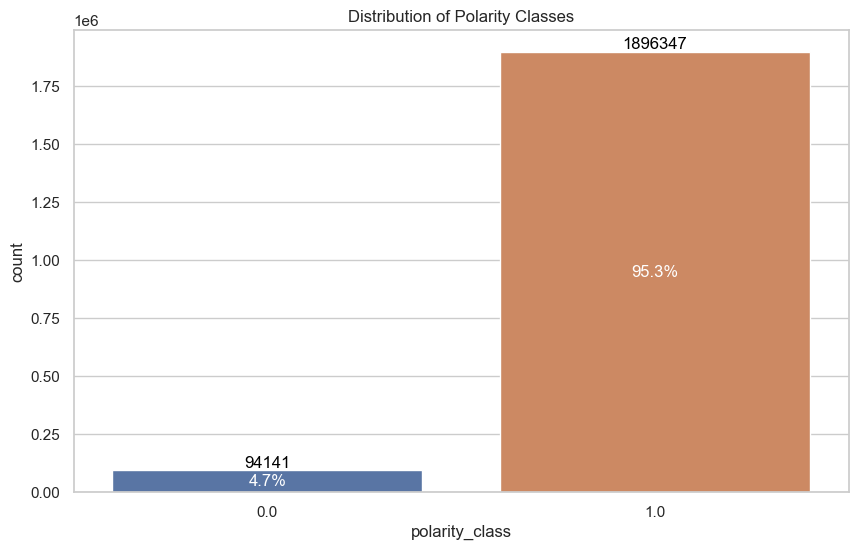

In [37]:
## Polarity class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_set, x='polarity_class')
plt.title('Distribution of Polarity Classes')

## Add count and percentage labels
total = len(train_set['polarity_class'])
for container in ax.containers:
    counts = [int(v.get_height()) for v in container]
    percentages = [f'{100 * v.get_height() / total:.1f}%' for v in container]
    ax.bar_label(container, labels=percentages, label_type='center', fontsize=12, color='white')
    for i, count in enumerate(counts):
        ax.text(container[i].get_x() + container[i].get_width() / 2, container[i].get_height(), count,
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()

***Insights:***
- There is a significant class imbalance in the data, with the majority class having a polarity of 1.0 (~ 95% of the dataset) compared to the minority class with a polarity of 0.0 (~ 5% of the dataset).
- This requires resampling the dataset

#### Q.5: How are the words in reviews correlated with the polarity class?

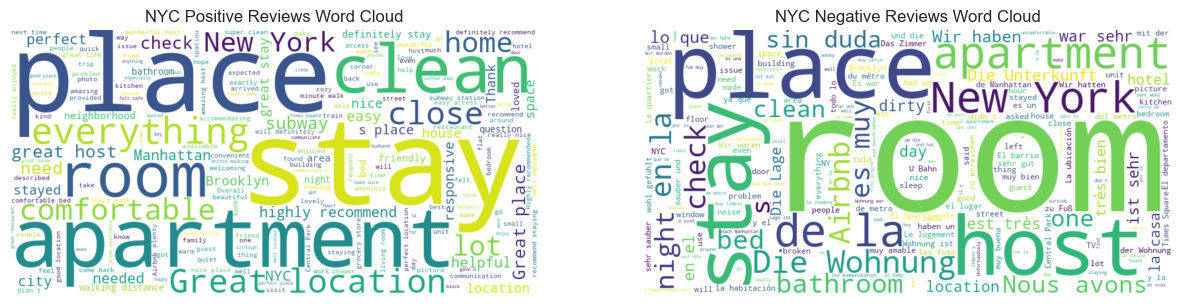

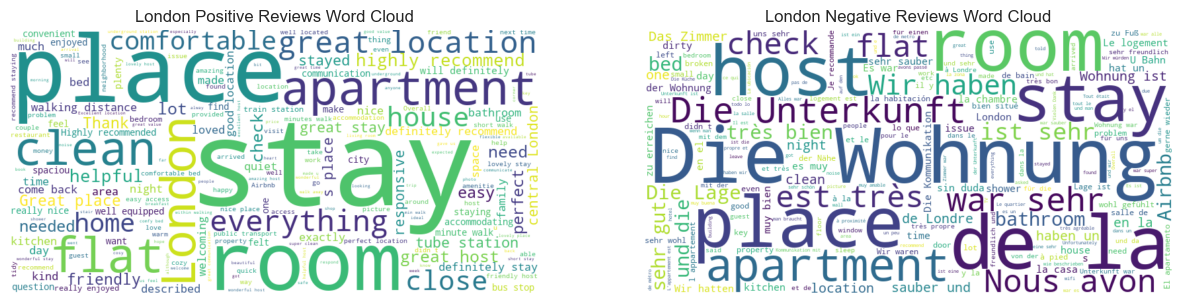

In [44]:
# Filter data for New York City and London
nyc_data = train_set[train_set['city'] == 'nyc']
london_data = train_set[train_set['city'] == 'london']

# Separate positive and negative reviews for NYC
nyc_positive_comments = ' '.join(nyc_data[nyc_data['polarity_class'] == 1.0]['comments'].tolist())
nyc_negative_comments = ' '.join(nyc_data[nyc_data['polarity_class'] == 0.0]['comments'].tolist())

# Separate positive and negative reviews for London
london_positive_comments = ' '.join(london_data[london_data['polarity_class'] == 1.0]['comments'].tolist())
london_negative_comments = ' '.join(london_data[london_data['polarity_class'] == 0.0]['comments'].tolist())

# Generate word clouds
nyc_positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(nyc_positive_comments)
nyc_negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(nyc_negative_comments)
london_positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(london_positive_comments)
london_negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(london_negative_comments)

# Plot word clouds
plt.figure(figsize=(15, 14))

# NYC Positive word cloud
plt.subplot(2, 2, 1)
plt.imshow(nyc_positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('NYC Positive Reviews Word Cloud')

# NYC Negative word cloud
plt.subplot(2, 2, 2)
plt.imshow(nyc_negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('NYC Negative Reviews Word Cloud')

plt.show()

# Plot word clouds
plt.figure(figsize=(15, 14))

# London Positive word cloud
plt.subplot(2, 2, 1)
plt.imshow(london_positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('London Positive Reviews Word Cloud')

# London Negative word cloud
plt.subplot(2, 2, 2)
plt.imshow(london_negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('London Negative Reviews Word Cloud')

plt.show()

***Insights:***
- The word clouds show that the frequent words in the positive class are clearly indicative of positive sentiment. However, the negative class is less consistent (for example, "tres bien" is frequent but classified as negative).
- The negative class appears to have more reviews in French, not just English.

#### Q.6: What is the distribution of the number of words in reviews for each city, and what are the minimum, maximum, and average word counts

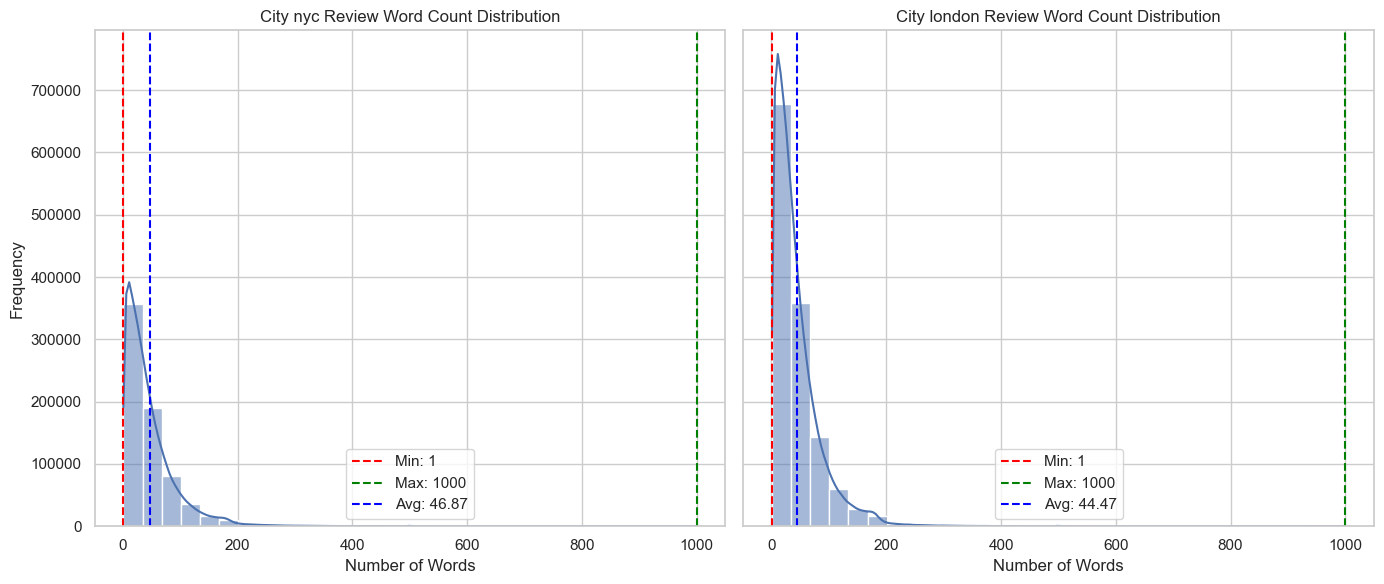

In [43]:
# Compute the number of words in each review
train_set['num_words'] = train_set['comments'].apply(lambda x: len(str(x).split()))

def plot_word_count_distribution(data, city_code, ax):
    # Filter data for the given city
    city_data = data[data['city'] == city_code]
    
    # Calculate statistics
    city_min = city_data['num_words'].min()
    city_max = city_data['num_words'].max()
    city_avg = city_data['num_words'].mean()
    
    # Plot distribution
    sns.histplot(city_data['num_words'], bins=30, kde=True, ax=ax)
    ax.axvline(city_min, color='red', linestyle='--', label=f'Min: {city_min}')
    ax.axvline(city_max, color='green', linestyle='--', label=f'Max: {city_max}')
    ax.axvline(city_avg, color='blue', linestyle='--', label=f'Avg: {city_avg:.2f}')
    ax.set_title(f'City {city_code} Review Word Count Distribution')
    ax.set_xlabel('Number of Words')
    ax.set_ylabel('Frequency')
    ax.legend()

# List of city codes
city_codes = train_set['city'].unique()

# Create subplots
fig, axes = plt.subplots(1, len(city_codes), figsize=(14, 6), sharey=True)

# Plot for each city
for ax, city_code in zip(axes, city_codes):
    plot_word_count_distribution(train_set, city_code, ax)

# Show the plots
plt.tight_layout()
plt.show()

***Insights:***
- Both cities have a close range in the distribution of the number of words in reviews, but London shows a slight diversity in review lengths compared to NYC.